<h1><center>Digit Recognition with PyTorch using the MNIST dataset</center></h1>

# Imports and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable

import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

np.random.seed(42)
seed = 42

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
predictions = pd.read_csv("sample_submission.csv")

df = train.copy()

# Exploratory Data Analysis

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(42000, 785)

In [5]:
X = df.drop("label", axis=1)
y = df.label

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

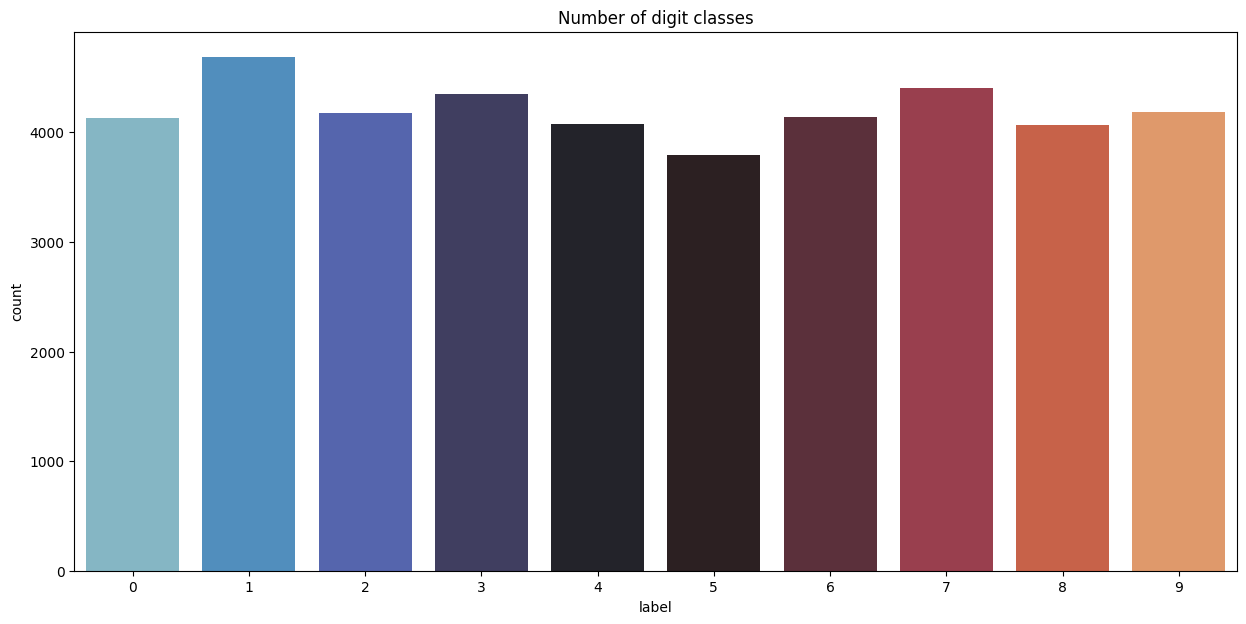

In [6]:
plt.figure(figsize=(15,7))
g = sns.countplot(x ='label', data = train, palette="icefire")
plt.title("Number of digit classes")
y.value_counts()

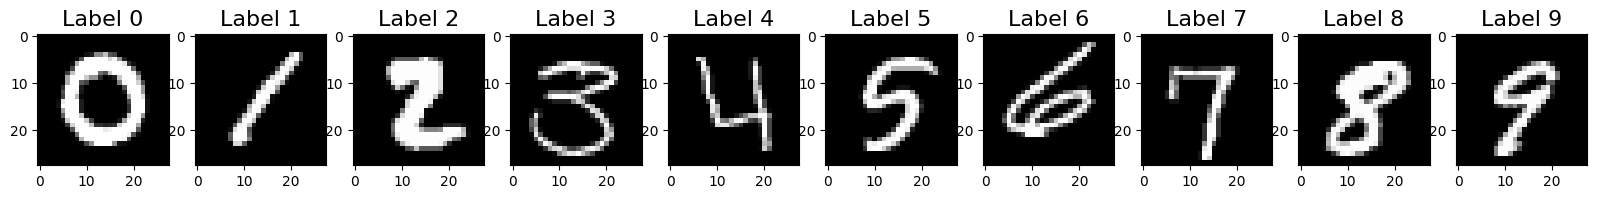

In [7]:
num_classes = 10

f, ax = plt.subplots(1, num_classes, figsize=(20,20))

for i in range(0, num_classes):
    sample = X[y == i].iloc[0].values.reshape(28, 28)
    ax[i].imshow(sample, cmap='gray')
    ax[i].set_title("Label {}".format(i), fontsize=16)

# Preparing the data

In [8]:
batch_size = 32
epochs = 3
learning_rate = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Separating the images and labels and creating a validation set

In [9]:
train_labels = train['label'].values
train_images = (train.iloc[:,1:].values).astype('float32')
test_images = (test.iloc[:,:].values).astype('float32')

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, 
    train_labels, 
    test_size=0.20,
    stratify=train_labels, 
    random_state=seed,
)


## Reshaping (28x28)

In [10]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

In [11]:
train_images.shape, val_images.shape, test_images.shape

((33600, 28, 28), (8400, 28, 28), (28000, 28, 28))

## Conversion to Torch Tensors and Normalization 

In [12]:
train_images_tensor = torch.tensor(train_images) / 255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

val_images_tensor = torch.tensor(val_images) / 255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

test_images_tensor = torch.tensor(test_images) / 255.0

## Loading the Data

In [13]:
train_loader = DataLoader(train_tensor, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=batch_size, num_workers=2, shuffle=False)

# Creating the Convolutional Neural Network 

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [15]:
model = Net()
model

Net(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3)

## Setting the Optimizer, Loss function and using the GPU if available

In [16]:
optimizer = optim.Adam(params=model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

## Training Loop Function 

In [17]:
train_losses = []
val_losses = []
val_accuracies = []

def train_model(num_epoch):
    model.train()
    exp_lr_scheduler.step()
    epoch_train_loss = 0
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * data.size(0)
          
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
            
    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

## Evaluation Function

In [18]:
def evaluate(data_loader):
    model.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in tqdm(data_loader):
            data = data.unsqueeze(1)
            data, target = data, target
        
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
        
            output = model(data)
        
            val_loss += F.cross_entropy(output, target, size_average=False).item()

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        val_loss /= len(data_loader.dataset)
        
        print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
            val_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))
        
        val_losses.append(val_loss)
        val_accuracies.append(100. * correct / len(data_loader.dataset))

## Training and Evaluation

In [19]:
for n in range(epochs):
    train_model(n)
    evaluate(val_loader)

101it [00:17,  8.81it/s]

Train Epoch: 0 [3200/33600 (10%)]	Loss: 0.473656


202it [00:28,  9.51it/s]

Train Epoch: 0 [6400/33600 (19%)]	Loss: 0.368249


301it [00:39,  8.77it/s]

Train Epoch: 0 [9600/33600 (29%)]	Loss: 0.306449


402it [00:50,  9.41it/s]

Train Epoch: 0 [12800/33600 (38%)]	Loss: 0.215513


502it [01:01,  9.92it/s]

Train Epoch: 0 [16000/33600 (48%)]	Loss: 0.384713


601it [01:12,  8.64it/s]

Train Epoch: 0 [19200/33600 (57%)]	Loss: 0.133601


702it [01:23,  9.36it/s]

Train Epoch: 0 [22400/33600 (67%)]	Loss: 0.242842


801it [01:34,  9.18it/s]

Train Epoch: 0 [25600/33600 (76%)]	Loss: 0.683190


901it [01:46,  8.97it/s]

Train Epoch: 0 [28800/33600 (86%)]	Loss: 0.206044


1001it [01:57,  8.49it/s]

Train Epoch: 0 [32000/33600 (95%)]	Loss: 0.093349


1050it [02:03,  8.51it/s]
100%|██████████| 263/263 [00:16<00:00, 16.38it/s]



Average Val Loss: 0.0606, Val Accuracy: 8247/8400 (98.179%)



101it [00:15,  9.20it/s]

Train Epoch: 1 [3200/33600 (10%)]	Loss: 0.262235


201it [00:27,  7.42it/s]

Train Epoch: 1 [6400/33600 (19%)]	Loss: 0.040047


301it [00:39,  9.26it/s]

Train Epoch: 1 [9600/33600 (29%)]	Loss: 0.083344


402it [00:51,  9.65it/s]

Train Epoch: 1 [12800/33600 (38%)]	Loss: 0.052942


501it [01:02,  8.62it/s]

Train Epoch: 1 [16000/33600 (48%)]	Loss: 0.577383


601it [01:13,  8.65it/s]

Train Epoch: 1 [19200/33600 (57%)]	Loss: 0.030675


701it [01:25,  9.41it/s]

Train Epoch: 1 [22400/33600 (67%)]	Loss: 0.917735


801it [01:37,  8.67it/s]

Train Epoch: 1 [25600/33600 (76%)]	Loss: 0.175043


901it [01:48,  8.66it/s]

Train Epoch: 1 [28800/33600 (86%)]	Loss: 0.140268


1000it [01:59,  8.18it/s]

Train Epoch: 1 [32000/33600 (95%)]	Loss: 0.157405


1050it [02:05,  8.35it/s]
100%|██████████| 263/263 [00:14<00:00, 18.62it/s]



Average Val Loss: 0.0539, Val Accuracy: 8257/8400 (98.298%)



101it [00:16,  8.72it/s]

Train Epoch: 2 [3200/33600 (10%)]	Loss: 0.014092


201it [00:27,  9.15it/s]

Train Epoch: 2 [6400/33600 (19%)]	Loss: 0.051084


301it [00:38,  9.33it/s]

Train Epoch: 2 [9600/33600 (29%)]	Loss: 0.183988


401it [00:49,  8.70it/s]

Train Epoch: 2 [12800/33600 (38%)]	Loss: 0.084558


501it [01:00,  9.58it/s]

Train Epoch: 2 [16000/33600 (48%)]	Loss: 0.145099


601it [01:11,  9.41it/s]

Train Epoch: 2 [19200/33600 (57%)]	Loss: 0.091885


701it [01:23,  6.45it/s]

Train Epoch: 2 [22400/33600 (67%)]	Loss: 0.238011


801it [01:34,  8.78it/s]

Train Epoch: 2 [25600/33600 (76%)]	Loss: 0.035210


901it [01:45,  8.64it/s]

Train Epoch: 2 [28800/33600 (86%)]	Loss: 0.146427


1001it [01:56,  9.60it/s]

Train Epoch: 2 [32000/33600 (95%)]	Loss: 0.027982


1050it [02:02,  8.55it/s]
100%|██████████| 263/263 [00:14<00:00, 18.22it/s]


Average Val Loss: 0.0491, Val Accuracy: 8287/8400 (98.655%)



## Plotting the Training and Validation Loss Curves + the Validation Accuracy Curve

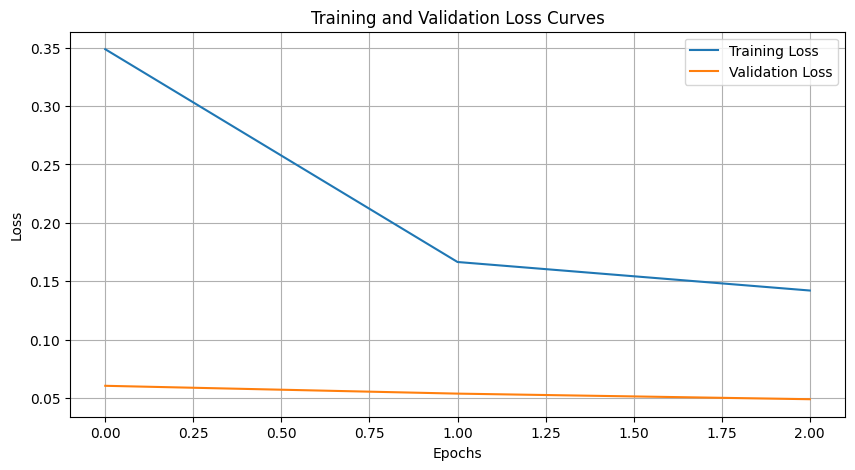

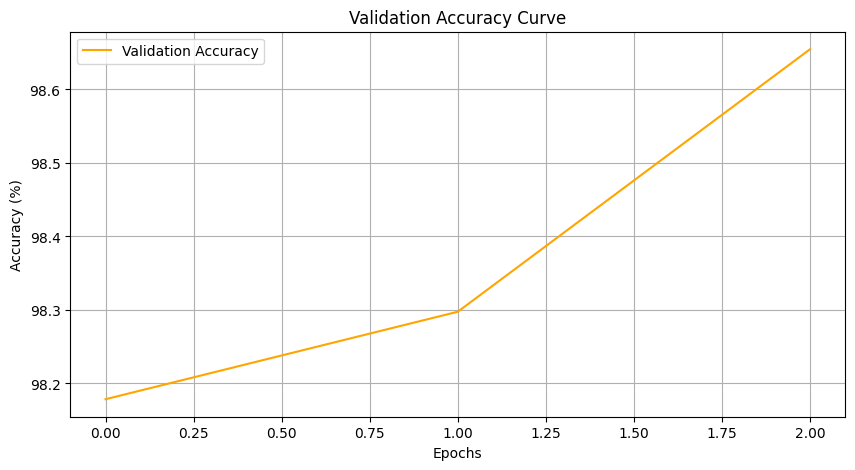

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

Our plots look great !

# Prediction on the Test set + Final submission 

In [29]:
def make_predictions(data_loader):
    model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in tqdm(enumerate(data_loader)):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [30]:
preds = make_predictions(test_loader)

875it [00:37, 23.26it/s]


In [31]:
predictions['Label'] = preds.numpy().squeeze()
predictions.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [52]:
predictions.to_csv("submission.csv", index=False)